# Segmenting and Clustering Neighborhoods in the city of Toronto, Canada

Let's download all the dependencies that we will need.

In [33]:
import pandas as pd
import numpy as np
import random
import requests

from bs4 import BeautifulSoup

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

#!pip install geopy
from geopy.geocoders import Nominatim
from IPython.display import Image 
from IPython.core.display import HTML 
from pandas.io.json import json_normalize

#!pip install folium==0.5.0
import folium



# Phase 1: Creating dataframe with postal codes

Using Beautiful Soup to get postal code

In [34]:
Code_Canada = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').content

In [35]:
soup = BeautifulSoup(Code_Canada,'html.parser')

Create a DataFrame from the necessary content on the page

In [36]:
table_code =[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_code.append(cell)

#### Tranform the data into a _pandas_ dataframe

In [37]:
df_code =pd.DataFrame(table_code)
df_code

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [38]:
df_code['Borough']

0                                             North York
1                                             North York
2                                       Downtown Toronto
3                                             North York
4                                           Queen's Park
                             ...                        
98                                             Etobicoke
99                                      Downtown Toronto
100    East TorontoBusiness reply mail Processing Cen...
101                                            Etobicoke
102                                            Etobicoke
Name: Borough, Length: 103, dtype: object

#### Renaming instances in the column Borough

In [39]:

df_code['Borough']=df_code['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})


In [40]:
df_code['Borough']

0                 North York
1                 North York
2           Downtown Toronto
3                 North York
4               Queen's Park
               ...          
98                 Etobicoke
99          Downtown Toronto
100    East Toronto Business
101                Etobicoke
102                Etobicoke
Name: Borough, Length: 103, dtype: object

In [41]:
df_code.shape

(103, 3)

# Phase 2: Getting latitude and longitude coordinates

#### Obtaining geocode through csv file

In [42]:
geocode_csv = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
geocode_csv.rename(columns={"Postal Code": "PostalCode"}, inplace=True)


#### Merge 
#### Quickly examine the resulting dataframe

In [43]:
df_geocode = pd.merge(df_code, geocode_csv, how ='right', on ='PostalCode')
df_geocode.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


# Phase 3: Exploring and grouping Toronto neighborhoods


#### Neighborhoods that contain the word Toronto

In [44]:
toronto_data = df_geocode[df_geocode['Borough'].str.contains('Toronto')]
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923


In [45]:
toronto_data['Borough'].value_counts()

Downtown Toronto          17
Central Toronto            9
West Toronto               6
East Toronto               4
East York/East Toronto     1
Downtown Toronto Stn A     1
East Toronto Business      1
Name: Borough, dtype: int64

In [46]:
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923


#### Viewing Toronto the neighborhoods in it.


In [47]:
lat = 43.651070
lon = -79.347015

Map_Toronto = folium.Map(location=[lat, lon],zoom_start=11)

folium.CircleMarker(
                    [lat, lon],
                    radius=5,
                    popup='Toronto',
                    fill=True,
                    color='red',
                    fill_color='red',
                    fill_opacity=0.7).add_to(Map_Toronto)

for lat, lon, borough, neighborhood in zip(toronto_data['Latitude'],toronto_data['Longitude'],toronto_data['Borough'],toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='blue',
        fill_opacity=0.5
        ).add_to(Map_Toronto)
Map_Toronto

In [48]:
toronto_data2 = toronto_data
property_clustering = toronto_data2.drop(['PostalCode','Borough','Neighborhood'],1)

In [49]:
property_clustering.head()

,Latitude,Longitude
37,43.676357,-79.293031
40,43.685347,-79.338106
41,43.679557,-79.352188
42,43.668999,-79.315572
43,43.659526,-79.340923


## Elbow metric

In [50]:
from sklearn.cluster import KMeans #para usar o KMeans
import matplotlib.pyplot as plt

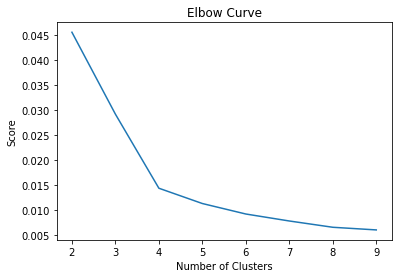

In [51]:
K_clusters = range(2,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

score = [kmeans[i].fit(property_clustering).inertia_ for i in range(len(kmeans))]

# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

## Silhouette Metrics

In [52]:
from sklearn.metrics import silhouette_score

for i in range(2,10):
  kmeans_ = KMeans(n_clusters=i).fit(property_clustering)
  labels_ = kmeans_.labels_
  coef = silhouette_score(property_clustering, labels_)
  
  print("N_cluster: {}, score: {}".format(i,coef))

N_cluster: 2, score: 0.3639680200162356
N_cluster: 3, score: 0.4292534555473007
N_cluster: 4, score: 0.5098950339346029
N_cluster: 5, score: 0.45414449319381117
N_cluster: 6, score: 0.4133654563829164
N_cluster: 7, score: 0.3949429464033581
N_cluster: 8, score: 0.33566980678125763
N_cluster: 9, score: 0.38237293417437995


#### Run k-means to cluster the neighborhood into 5 clusters

In [53]:
from sklearn.cluster import KMeans

In [54]:
k=4

kmeans = KMeans(n_clusters = k,random_state=0).fit(property_clustering)
kmeans.labels_
toronto_data2.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_data2.head()

,Cluster Labels,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,1,M4E,East Toronto,The Beaches,43.676357,-79.293031
40,1,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106
41,1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,1,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,1,M4M,East Toronto,Studio District,43.659526,-79.340923


#### Finally, let's visualize the resulting clusters

In [55]:
# create map
lat = 43.651070
lon = -79.347015
kclusters = 4
map_clusters = folium.Map(location=[lat, lon], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, neighborhood, cluster in zip(toronto_data2['Latitude'],toronto_data2['Longitude'],toronto_data2['Neighborhood'],toronto_data2['Cluster Labels']):
    label = '{}, {}, Cluster {}'.format(neighborhood, borough, cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters